## Subway Delay Data Analysis

In [ ]:
#imports
import re
import json
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#read the data and make columns categorical
df = pd.read_csv('/content/drive/MyDrive/subway_eda/ttc_subway_delay_data.csv', parse_dates = ['date'])

df['date'] = pd.Categorical(
    df.date, 
    categories = pd.date_range(start = '2018-01-01', end = '2022-12-31'), 
    ordered = True
)

df['weekday'] = pd.Categorical(
    df.weekday, 
    categories = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'],
    ordered = True
)

df.shape

(239273, 14)

In [ ]:
df

,date,time,year,month,day,weekday,hour,line_cleaned,station_cleaned,code,desc,min_delay,indicator_ns,indicator_station
0,2022-01-03,22:00,2022,1,1,Monday,22,YU_BD,VAUGHAN MC STATION,MUO,Miscellaneous Other,0.007246,1,1
1,2022-01-03,22:00,2022,1,1,Monday,22,YU_BD,HIGHWAY 407 STATION,MUO,Miscellaneous Other,0.007246,0,1
2,2022-01-03,22:00,2022,1,1,Monday,22,YU_BD,PIONEER VILLAGE STATION,MUO,Miscellaneous Other,0.007246,0,1
3,2022-01-03,22:00,2022,1,1,Monday,22,YU_BD,YORK UNIVERSITY STATION,MUO,Miscellaneous Other,0.007246,0,1
4,2022-01-03,22:00,2022,1,1,Monday,22,YU_BD,FINCH WEST STATION,MUO,Miscellaneous Other,0.007246,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239268,2018-12-31,22:34,2018,12,12,Monday,22,YU,DUNDAS STATION,PUMST,Station Stairway Incident,0.500000,1,1
239269,2018-12-31,22:36,2018,12,12,Monday,22,YU,DUNDAS STATION,SUDP,Disorderly Patron,3.000000,1,1
239270,2018-12-31,23:08,2018,12,12,Monday,23,YU,BLOOR STATION,MUIRS,Injured or ill Customer (In Station) - Medical...,0.500000,1,1
239271,2018-12-31,23:21,2018,12,12,Monday,23,YU,QUEENS PARK STATION,TUSC,Operator Overspeeding,0.500000,1,1


In [ ]:
df.dtypes

date                 category
time                   object
year                    int64
month                   int64
day                     int64
weekday              category
hour                    int64
line_cleaned           object
station_cleaned        object
code                   object
desc                   object
min_delay             float64
indicator_ns            int64
indicator_station       int64
dtype: object

# Delay time and station wise analysis 


Maximun delay events are between 0-1 mins

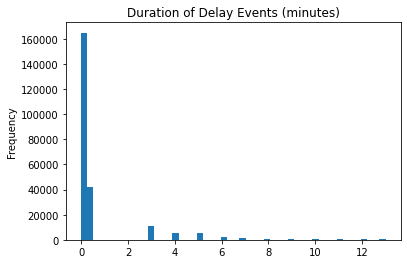

In [ ]:
df.min_delay.plot(
    kind = 'hist', 
    bins = 50, 
    range = (0, df.min_delay.quantile(0.99)), 
    title = 'Duration of Delay Events (minutes)'
)

In [ ]:
# line-station mapping
line_station_lookup = json.load(open('/content/drive/MyDrive/subway_eda/stations_ordered.json')) 

# station-line mapping
station_line_lookup = {v: k for k in line_station_lookup for v in line_station_lookup[k]}

In [ ]:
delay_dur_station_year = (df.groupby(['year', 'station_cleaned'])
                            .apply(lambda x: x.min_delay.sum())
                            .unstack('year'))

delay_dur_station_year.index = pd.Categorical(
    delay_dur_station_year.index,
    categories = line_station_lookup['YU'] + line_station_lookup['BD'] + \
                 line_station_lookup['SRT'] + line_station_lookup['SHP'],
    ordered = True
)

delay_dur_station_year.sort_index(inplace = True, ascending = False)

The plot below shows the total number of minutes spent in delays by station in each year and different color means station with different lines. We can observe Sheppard West and Wilson stations experienced an decrease in delays over time, while Vagaun MC, Finch and Eglinton and Kenney stations saw increase in delay. Most stations remained fairly stable over the years. 

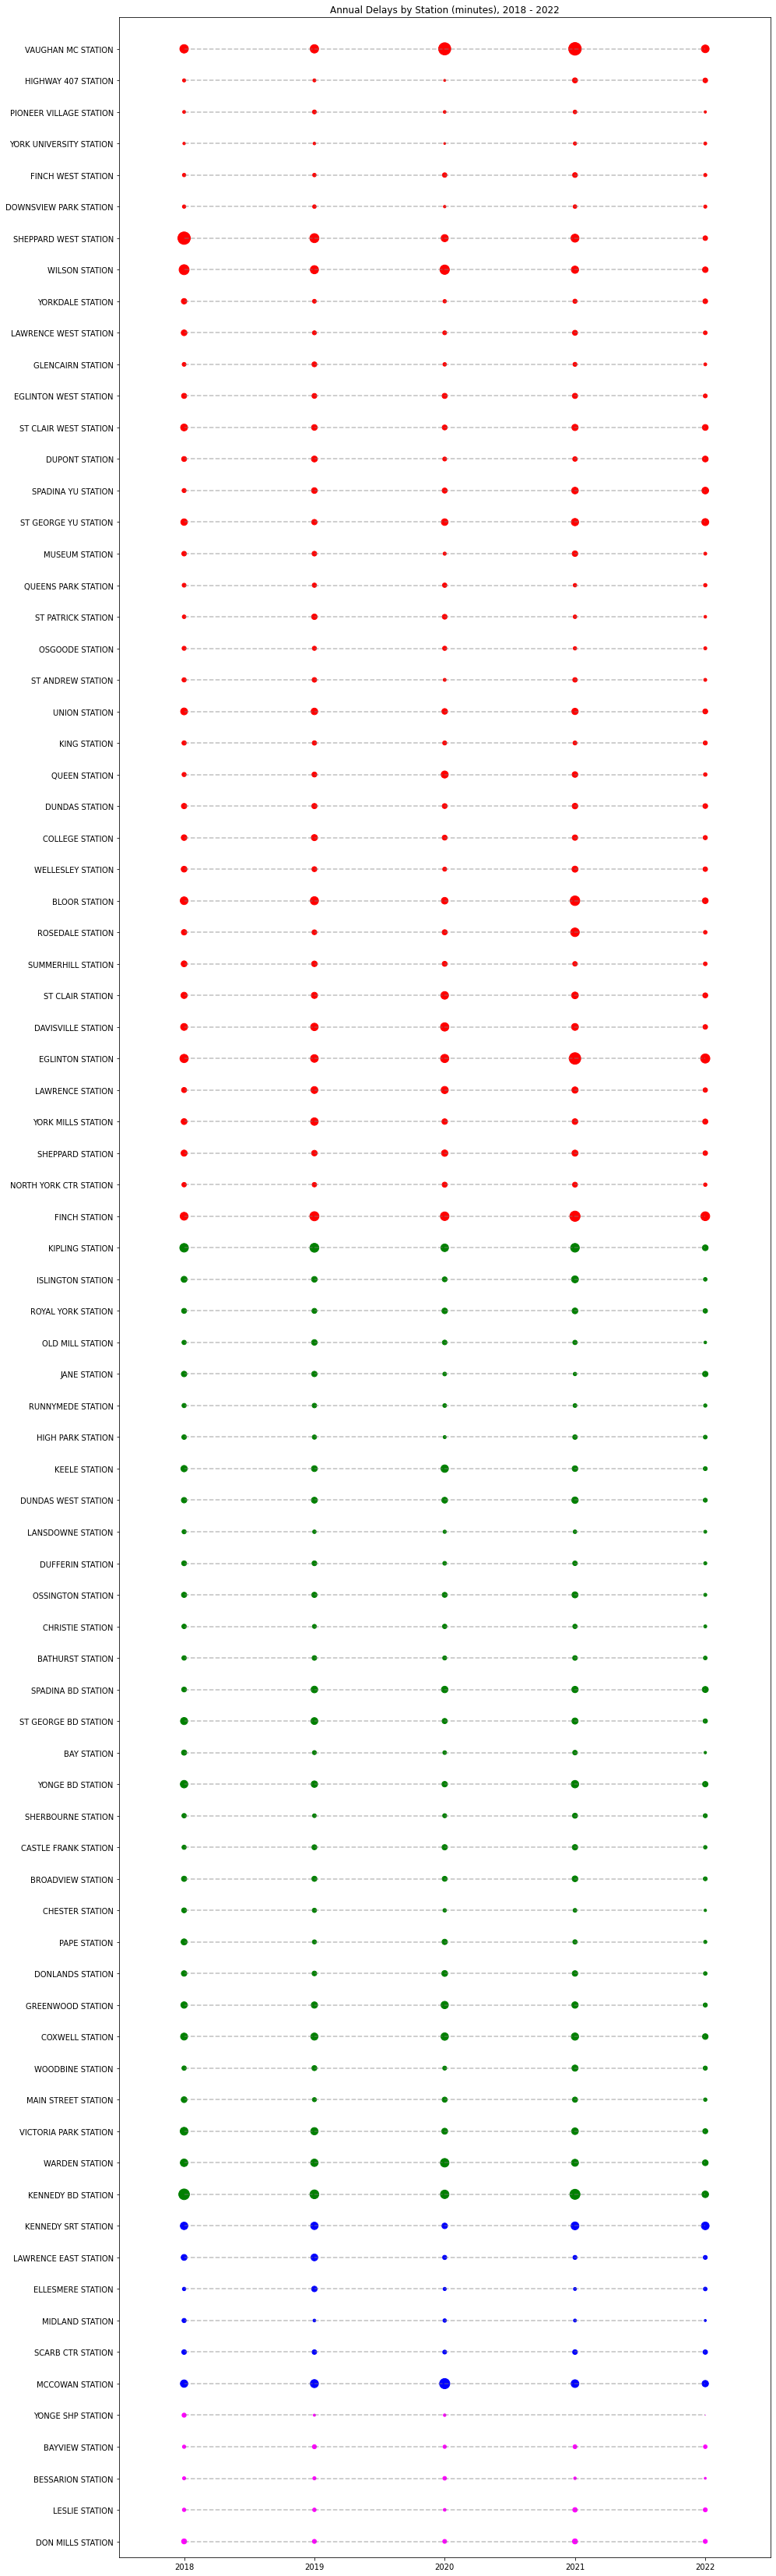

In [ ]:
cmap = {'YU': 'red', 'BD': 'green', 'SRT': 'blue', 'SHP': 'magenta'}

ncols = delay_dur_station_year.shape[1]
nrows = delay_dur_station_year.shape[0]

x_per_row = np.arange(0, delay_dur_station_year.shape[1])
y_per_col = np.arange(0, delay_dur_station_year.shape[0])

x = np.tile(x_per_row, nrows)
y = np.repeat(y_per_col, ncols)
z = delay_dur_station_year.values
c = np.repeat([cmap[station_line_lookup[station_i]] for station_i in delay_dur_station_year.index], ncols)

plt.figure(figsize = (15, 60))

plt.scatter(x, y, s = z / 12, alpha = 1, c = c)

for index, row in delay_dur_station_year.iterrows():
    plt.plot(x_per_row, np.repeat(index, ncols), ls = '--', c = 'gray', alpha = 0.5)

plt.xlim((-0.5, ncols - 0.5))
plt.ylim((-0.5, nrows))

plt.xticks(x_per_row, labels = np.arange(2018, 2023))
plt.yticks(y_per_col, labels = delay_dur_station_year.index)
plt.title('Annual Delays by Station (minutes), 2018 - 2022')

plt.show()

# Delay with longest interval, their occurance


In [ ]:
#deplays with more than an hour
longest_delays = df[df.min_delay > 60]

In [ ]:
pd.crosstab(longest_delays.desc, longest_delays.year).sort_values(by = 2018, ascending = False)

year,2018,2019,2020,2021,2022
desc,,,,,
Priority One - Train in Contact With Person,20,16,31,21,11
Weather Reports / Related Delays,7,5,0,0,1
Fire/Smoke Plan B - Source TTC,4,4,4,4,1
Force Majeure,3,0,0,0,0
Suspicious Package,3,1,1,0,1
ATC Project,2,0,1,3,1
Assault / Patron Involved,2,0,0,2,1
Bomb Threat,2,2,0,0,3
Passenger Other,1,0,0,0,1


Above analysis shows that the serious delays tend to be caused by when a train hits a person, fire/smoke, weather delays and infrastructure-related outages i.e rail, track switch, signals. The biggest contributor by far across years is train in contact with person.

In [ ]:
pd.crosstab(longest_delays.line_cleaned, longest_delays.year)

year,2018,2019,2020,2021,2022
line_cleaned,,,,,
BD,22,19,21,25,14
SHP,1,1,1,2,4
SRT,11,10,5,6,7
YU,20,20,26,21,12


Comparing the lines, there was a hike in the number of serious delays for BD and in 2021 and hike in 2020 for YU line



In [ ]:
pd.crosstab(longest_delays[longest_delays.line_cleaned == 'BD'].desc, 
            longest_delays[longest_delays.line_cleaned == 'BD'].year).sort_values(by = 2018, ascending = False)

year,2018,2019,2020,2021,2022
desc,,,,,
Priority One - Train in Contact With Person,12,8,18,12,5
Force Majeure,2,0,0,0,0
Passenger Other,1,0,0,0,0
Track Switch Failure - Signal Related Problem,1,1,0,1,1
Suspicious Package,1,1,0,0,0
Bomb Threat,1,1,0,0,2
Assault / Patron Involved,1,0,0,2,1
Fire/Smoke Plan B - Source TTC,1,3,1,3,1
Work Zone Problems - Track,1,0,0,0,0


In [ ]:
pd.crosstab(longest_delays[longest_delays.line_cleaned == 'YU'].desc, 
            longest_delays[longest_delays.line_cleaned == 'YU'].year).sort_values(by = 2018, ascending = False)

year,2018,2019,2020,2021,2022
desc,,,,,
Priority One - Train in Contact With Person,8,8,12,7,5
Fire/Smoke Plan B - Source TTC,3,1,3,1,0
ATC Project,2,0,1,3,1
Force Majeure,1,0,0,0,0
Weather Reports / Related Delays,1,0,0,0,0
Suspicious Package,1,0,1,0,1
Held By Polce - Non-TTC Related,1,0,0,1,0
Rail Related Problem,1,2,0,0,0
Assault / Patron Involved,1,0,0,0,0


# Cause for Delays

## By Count

The table below shows the number of delay events by cause relative to the total number of delays in that year. This measures the relative frequency of the various causes for delays, normalized for the number of delays in that particular year.

In [ ]:
delay_type_count = (df.groupby('year')
                      .apply(lambda x: x.groupby('desc')['indicator_ns'].sum() / x['indicator_ns'].sum())
                      .reset_index(drop = False)
                      .rename(columns = {'desc': 'delay_reason', 'indicator_ns': 'proportion'}))
    
delay_type_count.head()

,year,delay_reason,proportion
0,2018,ATC Operator Related,0.002893
1,2018,ATC Project,0.013188
2,2018,ATC RC&S Equipment,0.001226
3,2018,ATC Signals Other,0.000049
4,2018,Air Conditioning,0.002010


The charts below show the top 10 causes for delays (in terms of number of delay events) in 2018 and 2022, respectively, as well as the trend over time for those causes. Some observations:

- Most of the top delays appear to be caused by train passengers (e.g. passenger assistance alarm, disorderly patron, ill customer), and it has become an increasingly bigger cause for delays.
- The issue of operator overspeeding seems to be much better managed since 2018, even though they are still quite frequent



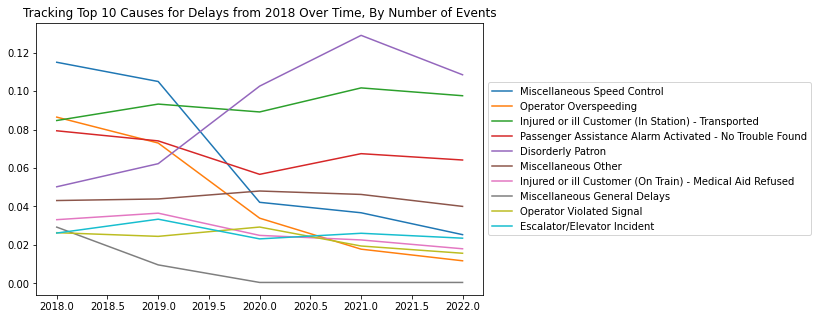

In [ ]:
top_2018_delays_count = (delay_type_count[delay_type_count.year == 2018].groupby('delay_reason')['proportion'].sum()
                                                                        .sort_values(ascending = False)
                                                                        .index.values[:10])

plt.figure(figsize = (8, 5))
                    
for delay in top_2018_delays_count:
    
    plt.plot(delay_type_count[delay_type_count.delay_reason == delay].year, 
             delay_type_count[delay_type_count.delay_reason == delay].proportion,
             label = delay)
                    
plt.legend(bbox_to_anchor = (1, 0.8), loc = "upper left")
plt.title('Tracking Top 10 Causes for Delays from 2018 Over Time, By Number of Events')

plt.show()

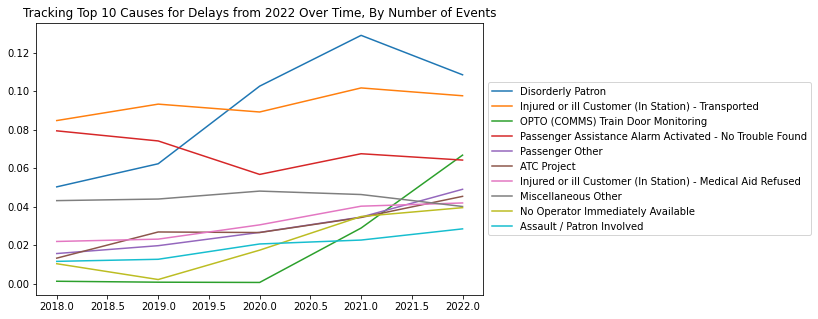

In [ ]:
top_2022_delays_count = (delay_type_count[delay_type_count.year == 2022].groupby('delay_reason')['proportion'].sum()
                                                                        .sort_values(ascending = False)
                                                                        .index.values[:10])

plt.figure(figsize = (8, 5))
                    
for delay in top_2022_delays_count:
    
    plt.plot(delay_type_count[delay_type_count.delay_reason == delay].year, 
             delay_type_count[delay_type_count.delay_reason == delay].proportion,
             label = delay)
                    
plt.legend(bbox_to_anchor = (1, 0.8), loc = "upper left")
plt.title('Tracking Top 10 Causes for Delays from 2022 Over Time, By Number of Events')

plt.show()

## By Duration

To account for the fact that not all delays are of equal severity (e.g. if a passenger assistance alarm was activated but turned out to be a false alarm, it would get resolved a lot faster than an injury), I repeated the above analysis for the duration of delays.

In [ ]:
delay_type_dur = (df.groupby('year')
                    .apply(lambda x: x.groupby('desc')['min_delay'].sum() / x['min_delay'].sum())
                    .reset_index(drop = False)
                    .rename(columns = {'desc': 'delay_reason', 'min_delay': 'proportion'}))

delay_type_dur.head()

,year,delay_reason,proportion
0,2018,ATC Operator Related,0.005809
1,2018,ATC Project,0.031134
2,2018,ATC RC&S Equipment,0.002655
3,2018,ATC Signals Other,0.000092
4,2018,Air Conditioning,0.003136


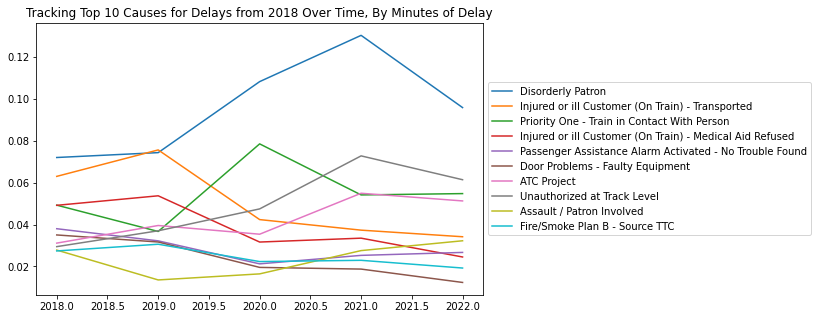

In [ ]:
top_2018_delays_dur = (delay_type_dur[delay_type_dur.year == 2018].groupby('delay_reason')['proportion'].sum()
                                                                  .sort_values(ascending = False)
                                                                  .index.values[:10])

plt.figure(figsize = (8, 5))
                    
for delay in top_2018_delays_dur:
    
    plt.plot(
        delay_type_dur[delay_type_dur.delay_reason == delay].year, 
        delay_type_dur[delay_type_dur.delay_reason == delay].proportion,
        label = delay
    )
                    
plt.legend(bbox_to_anchor = (1, 0.8), loc = "upper left")
plt.title('Tracking Top 10 Causes for Delays from 2018 Over Time, By Minutes of Delay')

plt.show()

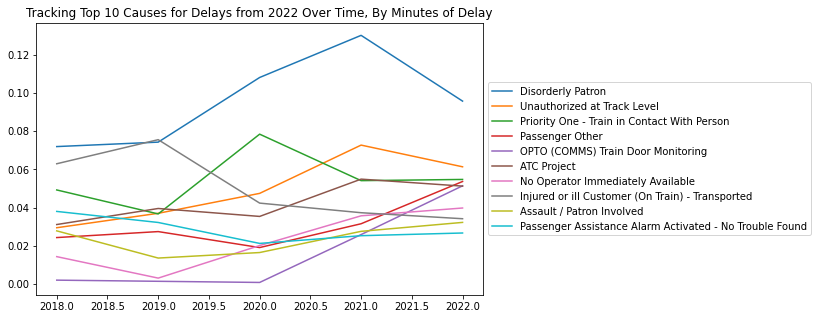

In [ ]:
top_2022_delays_dur = (delay_type_dur[delay_type_dur.year == 2022].groupby('delay_reason')['proportion'].sum()
                                                                  .sort_values(ascending = False)
                                                                  .index.values[:10])

plt.figure(figsize = (8, 5))
                    
for delay in top_2022_delays_dur:
    
    plt.plot(
        delay_type_dur[delay_type_dur.delay_reason == delay].year, 
        delay_type_dur[delay_type_dur.delay_reason == delay].proportion,
        label = delay
    )
                    
plt.legend(bbox_to_anchor = (1, 0.8), loc = "upper left")
plt.title('Tracking Top 10 Causes for Delays from 2022 Over Time, By Minutes of Delay')

plt.show()

Some observations from above analysis:
- Injured/ill customer and disorderly patrons account for a large proportion of delays by time (can increased crowding causing this?)
- We are getting less miscellaneous speed control-related delays
- Fire/smoke and faulty equipment are not as big of a problem


## By Subway Line

Next, I investigated the differences in the type of delays by subway line. For example, unlike the other three lines (except for a few stations), the Scarborough RT line is above ground, so could it face different operational issues because it is less protected by tunnels?

*Note*: I limited the analysis to delays on and after 2018 due to the addition of six stations to the YU line in Dec 2017.

In [ ]:
def get_mean_sd(x):
    return pd.Series({'delay_mean': x.min_delay.mean(), 
                      'delay_sd': x.min_delay.std(), 
                      'delay_sum': x.min_delay.sum(),
                       'n': x.indicator_ns.sum()})

In [ ]:
delay_type_line = df[(df.year > 2018) & 
                     (df.line_cleaned.isin([
                         'YU', 'BD', 'SRT', 'SHP'
                     ]))].groupby(['line_cleaned', 'desc']).apply(get_mean_sd)

delay_type_line.head()

delay_mean   delay_sd  delay_sum  \
line_cleaned desc                                                            
BD           ATC Project                   12.500000   0.707107       25.0   
             Air Conditioning               3.877778   1.620731      174.5   
             Alternating Current            4.500000   1.224745       27.0   
             Assault / Employee Involved    2.997908   6.016393      716.5   
             Assault / Patron Involved      3.804902  10.496546     1940.5   

                                              n  
line_cleaned desc                                
BD           ATC Project                    2.0  
             Air Conditioning              45.0  
             Alternating Current            6.0  
             Assault / Employee Involved  208.0  
             Assault / Patron Involved    510.0

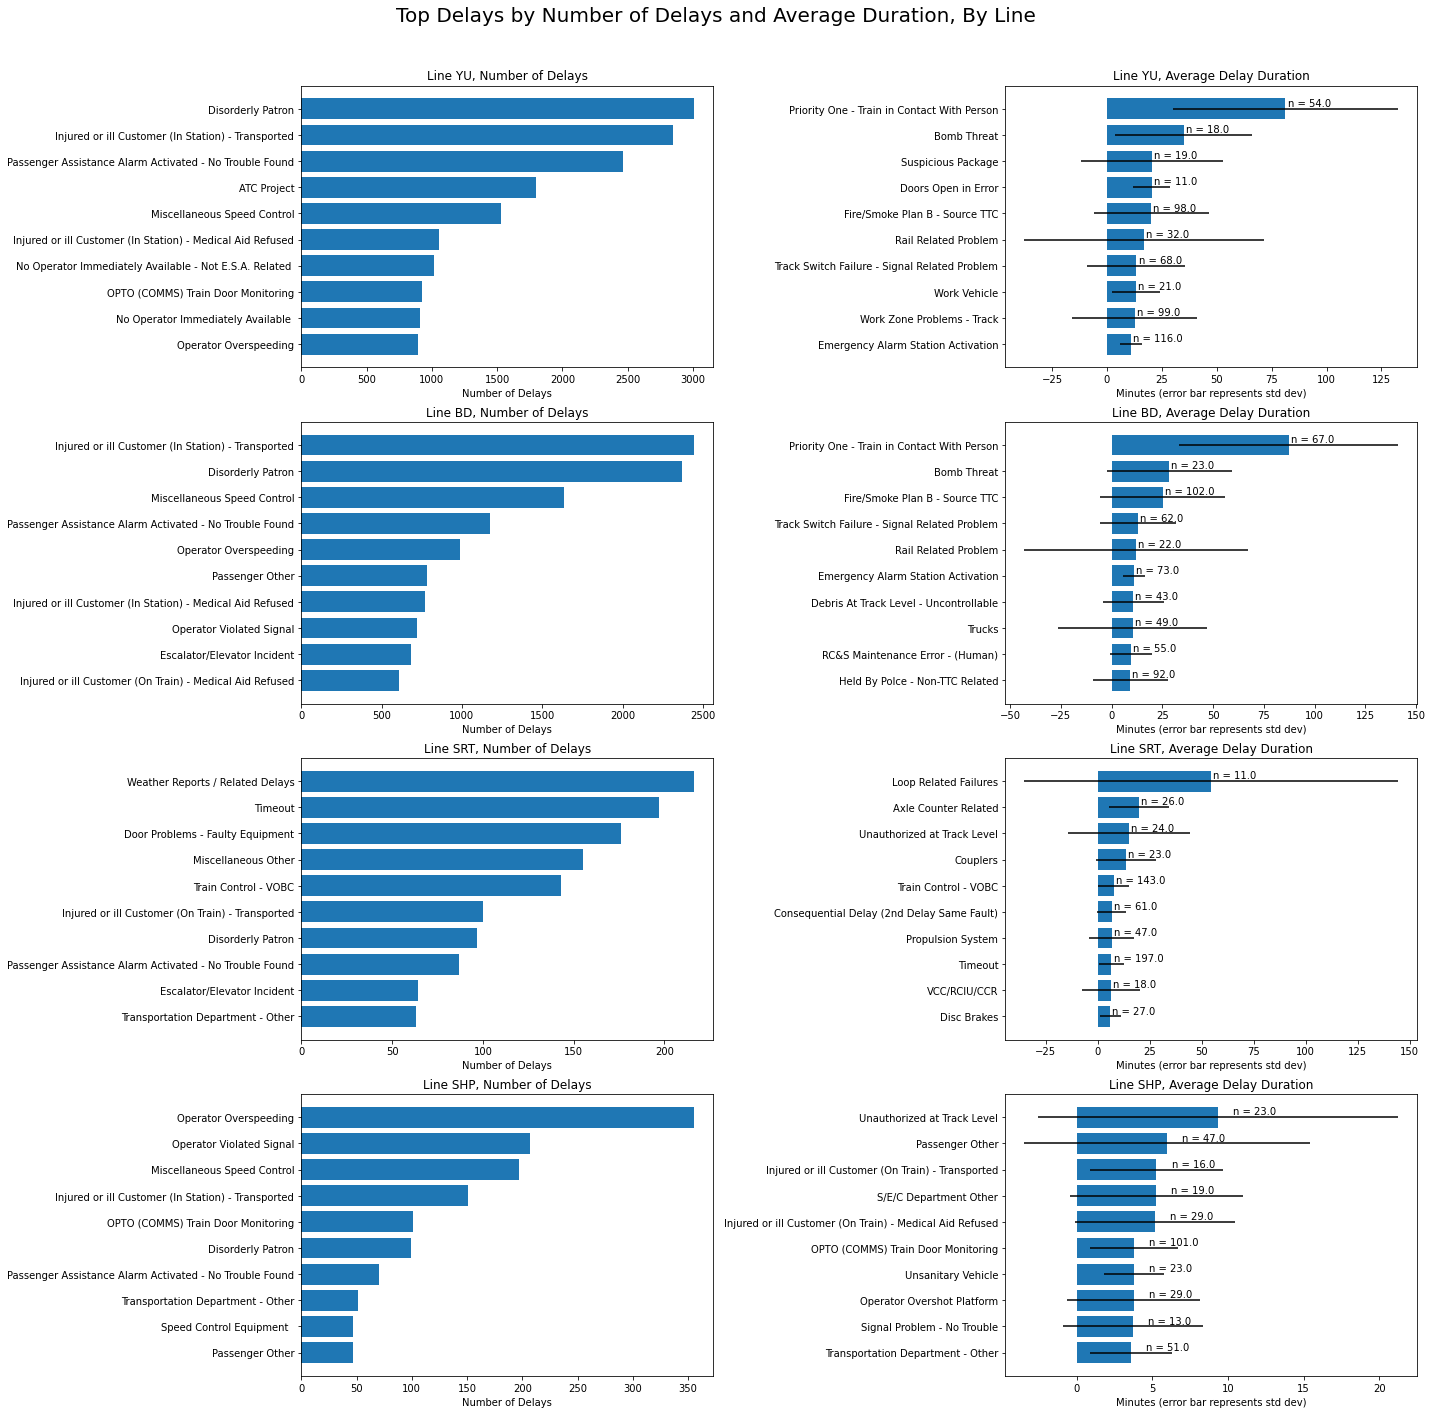

In [ ]:
n = 10 # Exclude extremely rare types when plotting top causes by average delay duration

fig, axes = plt.subplots(ncols = 2, nrows = 4, figsize = (20, 20))
fig.subplots_adjust(wspace = 0.8, hspace = 0.3)

for ii, line_i in enumerate(['YU', 'BD', 'SRT', 'SHP']):
    
    y_pos = np.arange(n)
    
    data_n = delay_type_line.loc[line_i].sort_values(by = 'n', ascending = False)[:n]    
    x_posn = data_n.n
    
    axes[ii][0].barh(y_pos, x_posn, align ='center')
    axes[ii][0].set_yticks(y_pos)
    axes[ii][0].set_yticklabels(data_n.index)
    axes[ii][0].invert_yaxis() 
    axes[ii][0].set_xlabel('Number of Delays')
    axes[ii][0].set_title(f'Line {line_i}, Number of Delays')
    
    data_m = delay_type_line[delay_type_line.n > 10].loc[line_i].sort_values(by = 'delay_mean', ascending = False)[:n]
    x_posm = data_m.delay_mean
    x_err = data_m.delay_sd
    
    axes[ii][1].barh(y_pos, x_posm, xerr = x_err, align ='center')
    
    for x, y, s in zip(x_posm, y_pos, data_m['n']):
        axes[ii][1].annotate(f'n = {s}', xy = (x, y), xytext = (x + 1, y - 0.1))
    
    axes[ii][1].set_yticks(y_pos)
    axes[ii][1].set_yticklabels(data_m.index)
    axes[ii][1].invert_yaxis()
    axes[ii][1].set_xlabel('Minutes (error bar represents std dev)')
    axes[ii][1].set_title(f'Line {line_i}, Average Delay Duration')

fig.suptitle('Top Delays by Number of Delays and Average Duration, By Line', fontsize = 20)
fig.tight_layout()
fig.subplots_adjust(top = 0.925)

plt.show()

As shown above, there are some overlap in top delays by line, but also some interesting differences:

- ill/injured customers, passenger assistance alarms and disorderly patrons are among the top causes regardless of line, so are overspeeding and speed control-related delays
- YU has experienced extensive delays related to ATC 
- SHP sees the fewest delays (could it have lower ridership or less train service?)
- As expected, SRT has a lot more delays related to weather in addition to equipment

# Seasonality

Lastly, I investigated seasonality of delay patterns. My hypothesis is more delays during rush hours on weekdays, and less delay in summer months as more people go away for vacation. 

In [ ]:
seasonal_summ = (df.groupby(['date', 'year', 'month', 'weekday', 'hour'])
                   .apply(get_mean_sd)
                   .reset_index(drop = False))

seasonal_summ.head()

,date,year,month,weekday,hour,delay_mean,delay_sd,delay_sum,n
0,2018-01-01,2018,1,Sunday,0,NaN,NaN,NaN,NaN
1,2018-01-01,2018,1,Sunday,1,NaN,NaN,NaN,NaN
2,2018-01-01,2018,1,Sunday,2,NaN,NaN,NaN,NaN
3,2018-01-01,2018,1,Sunday,3,NaN,NaN,NaN,NaN
4,2018-01-01,2018,1,Sunday,4,NaN,NaN,NaN,NaN


To normalize for year, each series was rescaled by the first value (i.e. at hour 0). As expected, on an hourly basis, delays are more common during the morning and evening rush hours. This has been consistent across years. 

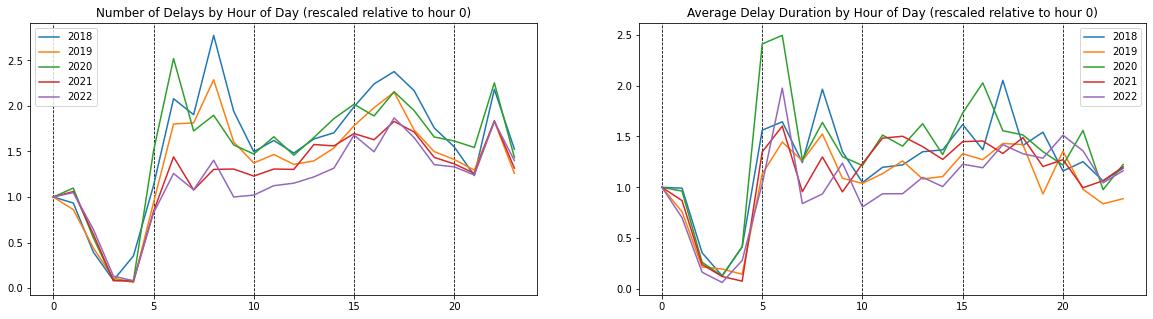

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, nrows = 1, figsize = (20, 5))

for name, group in seasonal_summ.groupby('year'):
    
    ax1.plot(group.groupby('hour')['n'].sum() / group.groupby('hour')['n'].sum()[0], label = name)
    
    temp_i = group.groupby('hour')['delay_sum'].agg(['mean']).reset_index(drop = False)
    ax2.plot(temp_i['hour'], temp_i['mean'] / temp_i['mean'][0], label = name)
    
ax1.grid(b = True, which = 'major', axis = 'x', color = 'black', linestyle = '--')
ax1.set_title('Number of Delays by Hour of Day (rescaled relative to hour 0)')
ax1.legend()

ax2.grid(b = True, which = 'major', axis = 'x', color = 'black', linestyle = '--')
ax2.set_title('Average Delay Duration by Hour of Day (rescaled relative to hour 0)')
ax2.legend()

plt.show()

On a weekly basis, delays are worse Monday through Friday, and drop off significantly on the weekends. During the week, the delay duration seems to relatively lower on Fridays. 

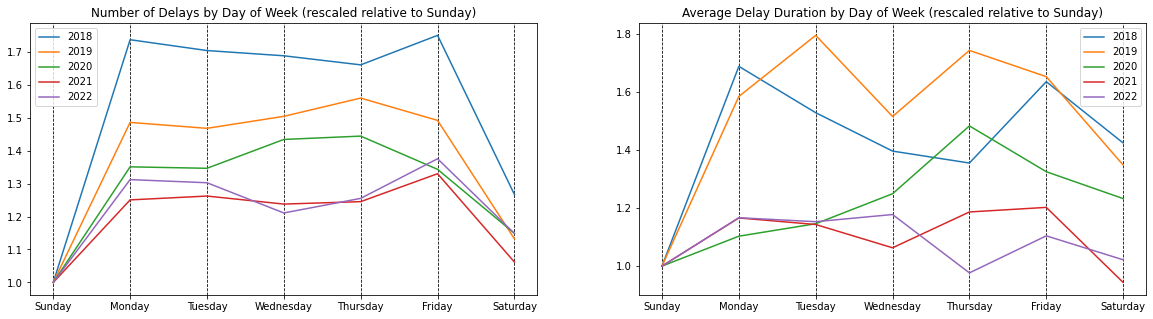

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, nrows = 1, figsize = (20, 5))

for name, group in seasonal_summ.groupby('year'):
    
    ax1.plot(['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'], 
             group.groupby('weekday')['n'].sum() / group.groupby('weekday')['n'].sum()[0], 
             label = name)
    
    temp_i = (group.groupby(['date', 'weekday'])['delay_sum'].sum()
                   .groupby('weekday')
                   .agg(['mean'])
                   .reset_index(drop = False))
    ax2.plot(['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday'],
             temp_i['mean'] / temp_i['mean'][0], label = name)
    
ax1.grid(b = True, which = 'major', axis = 'x', color = 'black', linestyle = '--')
ax1.set_title('Number of Delays by Day of Week (rescaled relative to Sunday)')
ax1.legend()

ax2.grid(b = True, which = 'major', axis = 'x', color = 'black', linestyle = '--')
ax2.set_title('Average Delay Duration by Day of Week (rescaled relative to Sunday)')
ax2.legend()

plt.show()

On a monthly basis, the summer months do not correspond to periods of low delays. In fact, I detected no obvious consistent seasonality patterns by month. 

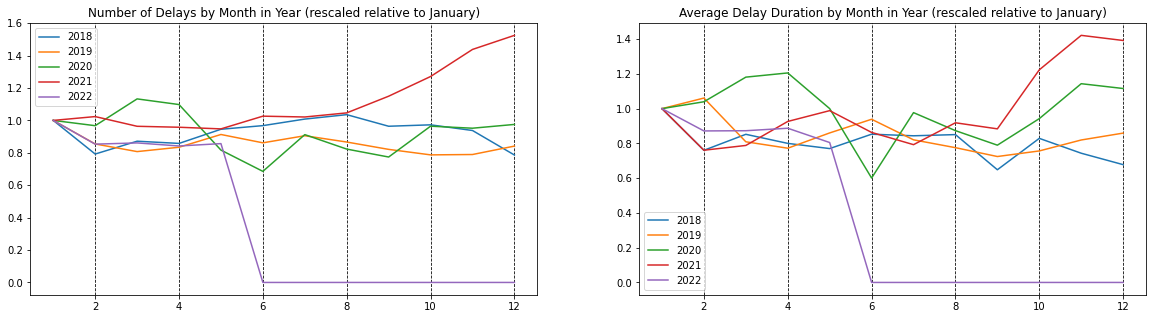

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, nrows = 1, figsize = (20, 5))

for name, group in seasonal_summ.groupby('year'):
        
    ax1.plot(group.groupby('month')['n'].sum() / group.groupby('month')['n'].sum()[1], label = name)

    temp_i = (group.groupby(['date', 'month'])['delay_sum'].sum()
                   .groupby('month')
                   .agg(['mean'])
                   .reset_index(drop = False))
    ax2.plot(temp_i['month'], temp_i['mean'] / temp_i['mean'][0], label = name)
    
ax1.grid(b = True, which = 'major', axis = 'x', color = 'black', linestyle = '--')
ax1.set_title('Number of Delays by Month in Year (rescaled relative to January)')
ax1.legend()

ax2.grid(b = True, which = 'major', axis = 'x', color = 'black', linestyle = '--')
ax2.set_title('Average Delay Duration by Month in Year (rescaled relative to January)')
ax2.legend()

plt.show()

Annually, there was an uptick in delays in 2018. It is encouraging to see improvements in 2020 compared to the year before, but it is gets worse in 2021

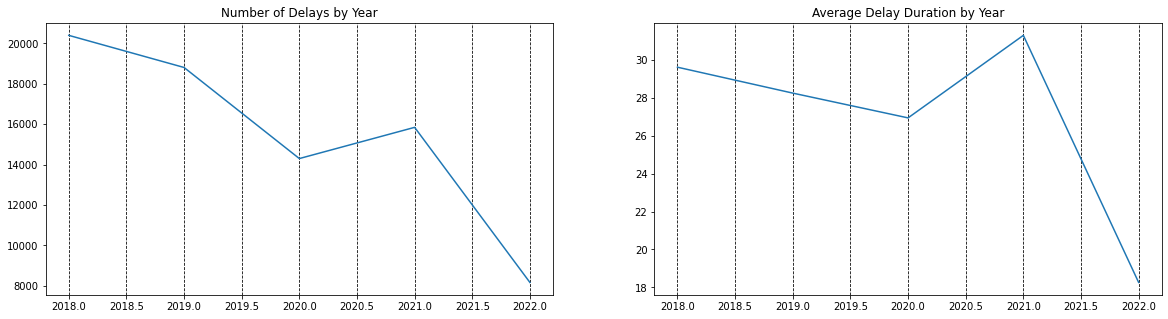

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols = 2, nrows = 1, figsize = (20, 5))

ax1.plot(seasonal_summ.groupby('year')['n'].sum())

temp = (seasonal_summ.groupby(['date', 'year'])['delay_sum'].sum()
                     .groupby('year')
                     .agg(['mean'])
                     .reset_index(drop = False))
ax2.plot(temp['year'], temp['mean'])

ax1.grid(b = True, which = 'major', axis = 'x', color = 'black', linestyle = '--')
ax1.set_title('Number of Delays by Year')

ax2.grid(b = True, which = 'major', axis = 'x', color = 'black', linestyle = '--')
ax2.set_title('Average Delay Duration by Year')

plt.show()

# Conclusion

 

According to the analysis of delays with longest duration by line (By-Subway-Line) and proportion of lengthy delays by cause (Longest-Delays), most types of delays are fairly short-lived, as long as it is not the rare bomb threat, suspicious package, police investigation, fire/smoke, doors opening in error or train hitting a person.

According to the visualization Monday is the day to avoid to reduce the chances of being stuck in more delays, while Tuesday appears to be the best day, although the trend is not very clear and could have been affected by outlier events.

- YU and BD lines are not impacted by weather (maybe because many stations on those lines are underground), but increasingly more by customer-related incidents (e.g. disruptive and ill patrons). On the other hand, weather effects are stronger for the SRT ine, which is the above-ground light rail line
- The vast majority of delay events are very short-lived ,in the range of a few minutes, unless they are caused by injury at track level, fire or equipment/infrastructure-related outages
- The frequently occuring types of delays (e.g. passenger assistance alarm activation on train) tend to be quick to resolve, while serious issues are rare
- Overall, there have been a drop in operator overspeeding and miscellaneous speed control events reported 
- Rush hours and weekdays experience more delays, but I did not find any noticeable month/seasonal trends, possibly because the two most popular lines (i.e. YU and BD lines) are not really affected by weather and the ridership population is stable throughout the year 
- Out of the last 5 years, 2018 was the worst year in terms of delays - there was a sharp rise in passenger-related delays